Referencia: [ArcFace](https://pypi.org/project/arcface/)

# Setup

In [ ]:
# For face recognition
!pip install arcface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 4.3 MB/s 
     |████████████████████████████████| 60.9 MB 73 kB/s 
     |████████████████████████████████| 63 kB 840 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you h

# Libraries

In [1]:
from arcface import ArcFace
import numpy as np
import os, fnmatch
import seaborn as sn
import numpy as np
import cv2
from collections import namedtuple
from tqdm.auto import tqdm
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt



In [2]:
face_rec = ArcFace.ArcFace()

# Functions

In [3]:
# List of files of a directory
def dirfiles(img_path,img_ext):
  # Example: img_names = dirfiles('/content/Test/','X*.jpg')
  img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
  return img_names

# Embedding of a file image
def image2arcface(image_path):
  # Example: x = image2arcface('/content/Test/B000011.jpg')
  embedding = face_rec.calc_emb(image_path)
  return embedding

# Embedding of a file list
def imagelist2arcface(img_path,img_names):
  # Example: img_names = dirfiles('/content/Test/','X*.jpg')
  #          X = imagelist2arcface('/content/Test/',img_names)
    n = len(img_names)
    embeddings = np.zeros((n,512))
    for i in tqdm(range(n)):
      embeddings[i,:] = image2arcface(img_path+img_names[i])
    return embeddings

# Labels (ground truth): m face images per subject
def face_labels(Z,m):
  n = Z.shape[0]
  y = np.zeros((n,),int)
  for i in range(n):
    y[i] = i/m
  return y

def plot_features(X,d,st,show=1):
    dmin = int(np.min(d)) 
    dmax = int(np.max(d)) 
    if show==1:
      plt.figure(figsize=(12,8))
    for j in range(dmin,dmax+1):
        plt.scatter(X[d==j,0],X[d==j,1],label=str(j),s=27)
    plt.grid(True)
    plt.legend()
    plt.xlabel('$x_1$',fontsize=14)
    plt.ylabel('$x_2$',fontsize=14)
    plt.title('Feature Space - '+st,fontsize=14)
    if show==1:
        plt.show()


# ORL dataset

In [ ]:
!wget https://www.dropbox.com/s/cdjqldkfrobnbex/ORL.zip?dl=0
!unzip -qq ORL.zip

--2022-06-08 12:05:51--  https://www.dropbox.com/s/w2y8uo7p0qgx6qr/ORL.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/w2y8uo7p0qgx6qr/ORL.zip [following]
--2022-06-08 12:05:51--  https://www.dropbox.com/s/raw/w2y8uo7p0qgx6qr/ORL.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccdcafc214826ec562d64f2ea96.dl.dropboxusercontent.com/cd/0/inline/BmwV_WPpjohyItPMg-xc8Yf6cdOejz5hIvrh4lCRGxpDEPbMueUGMBSQqBsow-fCEkCbMuD940Pi3VfGxHNl7eWQajg3EJ-zl6AVwO9ETFkO6qvvKJZ_djVUHh0p0LD4mNKQ1VhFuVONYt2QtUSPhQywC5kxLXHcd8CtRsyQ5CUXag/file# [following]
--2022-06-08 12:05:52--  https://uccdcafc214826ec562d64f2ea96.dl.dropboxusercontent.com/cd/0/inline/BmwV_WPpjohyItPMg-xc8Yf6cdOejz5hIvrh4lCRGxpDEPbMueUGMBSQqBsow-fCEkCbMuD940Pi3VfGx

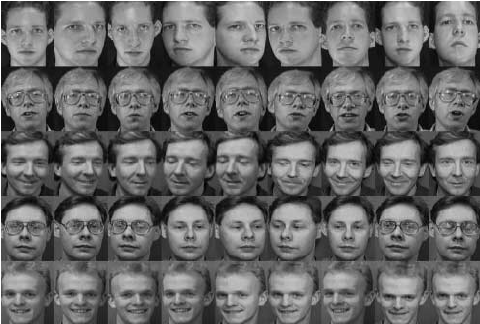

## Embedding extraction

In [ ]:
fpath = 'ORL/'
img_names = dirfiles(fpath,'face*.png')
X         = imagelist2arcface(fpath,img_names)

  0%|          | 0/400 [00:00<?, ?it/s]

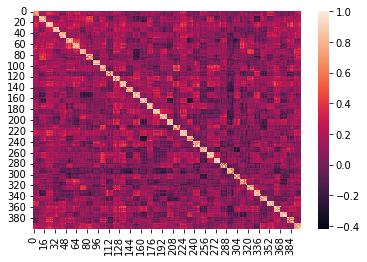

In [ ]:
Z = np.dot(X,X.T)
sn.heatmap(Z, annot=False)

In [ ]:
y = face_labels(Z,10) # ground truth

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=40)
model.fit(X)
yhat = model.predict(X)


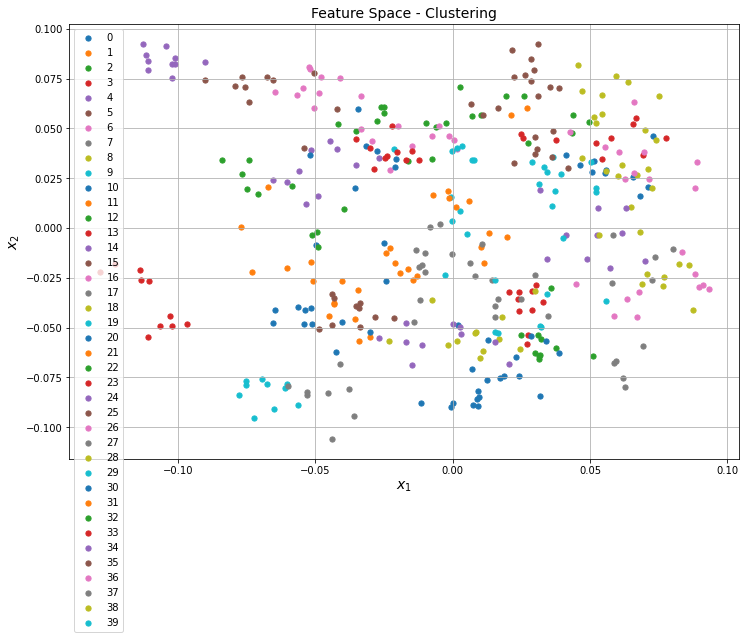

In [ ]:
from sklearn.decomposition import FastICA,PCA
from sklearn.cross_decomposition import PLSRegression  

clt_model = FastICA(n_components=2, random_state=0)
#clt_model = PCA(n_components=2, random_state=0)
#clt_model = PLSRegression(n_components=2)    

clt_model.fit(X,yhat)    


Xs = clt_model.transform(X)
plot_features(Xs,yhat,'Clustering')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


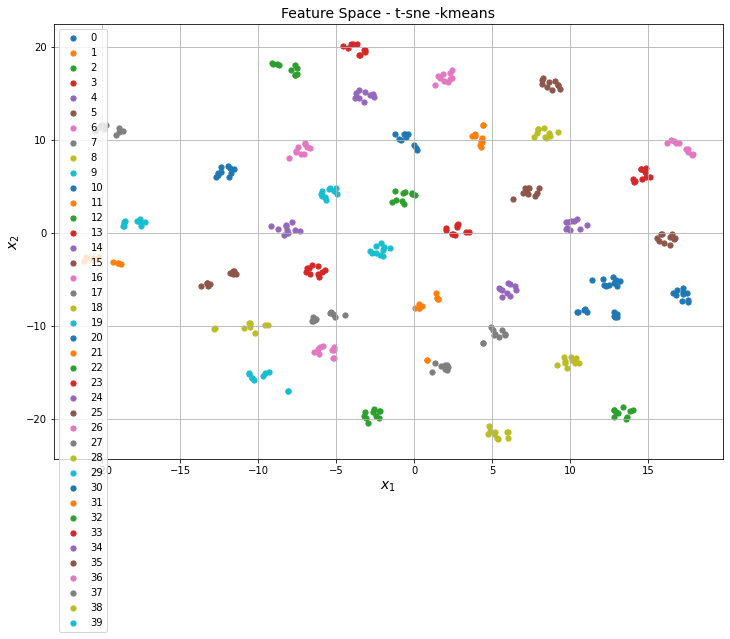

In [ ]:
from sklearn import manifold

model = manifold.TSNE(n_components=2, init='random',random_state=0)
Y = model.fit_transform(X)
plot_features(Y,yhat,'t-sne -kmeans')

# Show one cluster

In [ ]:
i=-1

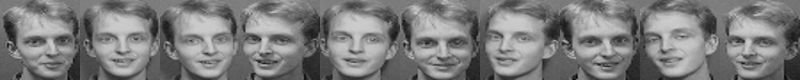

In [ ]:
i = i+1

ii = np.where(yhat==i)[0]

n = len(ii)

for k in range(n):
  j = ii[k]
  I = cv2.imread(fpath+img_names[j])
  J = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
  if k==0:
    II = J
  else:
    II = np.concatenate((II,J),axis=1)

plt.imshow(II)
  
